In [36]:
# model creation
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
# from scipy.stats import uniform
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

import keras

os.chdir('../data/')

data = pd.read_pickle('procesada/data_plus_census.pkl')
#data = data.query('state=="sp"').dropna()
data = data.dropna()

In [37]:
data.final_decision.value_counts()

R    19273
A    13820
Name: final_decision, dtype: int64

In [3]:
def model_metrics(model_search):
    print('Best parameters: {0}'.format(model_search.best_params_))
    print('Best score: {0:.3f}'.format(model_search.best_score_))
    print('Best model score in test: {0:.3f}'.format(accuracy_score(y_test, model_search.best_estimator_.predict(X_test))))
    print('Best model ROC in test: {0:.3f}'.format(roc_auc_score(y_test, model_search.best_estimator_.predict_proba(X_test)[:,1])))
    print('Confussion matrix in test normalized:\n')
    print(pd.crosstab(y_test, model_search.best_estimator_.predict(X_test), normalize=True)*100)
    print("")
    print('Confussion matrix in test:\n')
    print(confusion_matrix(y_test, model_search.best_estimator_.predict(X_test)))
    print("")
    print('Classification report in test: \n')
    print(classification_report(y_test, model_search.best_estimator_.predict(X_test)))

In [38]:
features = data[[x for x in data.columns if data[x].dtype!='object']]
label = pd.to_numeric(data.final_decision=='A').astype(np.int8)

X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=42)



# Logistic regression

In [5]:
pipeline_logistic = Pipeline([('scaler', StandardScaler()), 
                              ('model', SGDClassifier(loss='log', penalty='elasticnet', random_state=2020, fit_intercept=True))],
                             verbose = False)

In [6]:
params_logistic = {'model__alpha': np.arange(0, 10, 0.2),
                   'model__l1_ratio': np.arange(0.01, 1, 0.02)}

model_logistic = RandomizedSearchCV(pipeline_logistic,
                                    params_logistic, 
                                    random_state=2020,
                                    scoring='accuracy',
                                    cv=5,
                                    n_iter=20,
                                    verbose=1,
                                    n_jobs=5)
model_logistic = model_logistic.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   16.2s
[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:   32.5s finished


In [7]:
model_metrics(model_logistic)

Best parameters: {'model__l1_ratio': 0.15, 'model__alpha': 0.6000000000000001}
Best score: 0.667
Best model score in test: 0.670
Best model ROC in test: 0.771
Confussion matrix in test normalized:

col_0                   0          1
final_decision                      
0               55.688170   2.749660
1               30.246261  11.315909

Confussion matrix in test:

[[3686  182]
 [2002  749]]

Classification report in test: 

              precision    recall  f1-score   support

           0       0.65      0.95      0.77      3868
           1       0.80      0.27      0.41      2751

    accuracy                           0.67      6619
   macro avg       0.73      0.61      0.59      6619
weighted avg       0.71      0.67      0.62      6619



# Random forest

In [8]:
rf_acceptance = RandomForestClassifier(n_estimators=50)
pipeline_rf = Pipeline([('scaler', StandardScaler()), 
                        ('select_model', SelectFromModel(rf_acceptance, prefit=False)),
                        ('model', RandomForestClassifier(random_state=2020))],
                       verbose = False)

In [9]:
params_rf = {
    'model__n_estimators': [100, 200, 500],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 5, 10]
}

In [10]:
model_rf = RandomizedSearchCV(pipeline_rf, params_rf, cv=5, random_state=2020, n_iter=5, verbose=1, n_jobs=5)
model_rf = model_rf.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  25 out of  25 | elapsed:  8.4min finished


In [11]:
model_metrics(model_rf)

Best parameters: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 10}
Best score: 0.731
Best model score in test: 0.736
Best model ROC in test: 0.797
Confussion matrix in test normalized:

col_0                   0          1
final_decision                      
0               47.983079  10.454751
1               15.954072  25.608098

Confussion matrix in test:

[[3176  692]
 [1056 1695]]

Classification report in test: 

              precision    recall  f1-score   support

           0       0.75      0.82      0.78      3868
           1       0.71      0.62      0.66      2751

    accuracy                           0.74      6619
   macro avg       0.73      0.72      0.72      6619
weighted avg       0.73      0.74      0.73      6619



# XGBoost

In [12]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


params_xgb = {'min_child_weight': [1, 5, 10],
              'gamma': [0.5, 1, 1.5, 2, 5],
              'subsample': [0.6, 0.8, 1.0],
              'colsample_bytree': [0.6, 0.8, 1.0],
              'max_depth': [3, 4, 5],
              'n_estimators': [100, 200, 300]
             }

xgb_instace = xgb.XGBClassifier(learning_rate=0.01,
                                objective='binary:logistic')

model_xgb = RandomizedSearchCV(xgb_instace, 
                               params_xgb, 
                               n_iter=15,
                               scoring='roc_auc',
                               n_jobs=5, 
                               cv=5, 
                               verbose=2,
                               random_state=2020)

model_xgb = model_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed: 18.7min
[Parallel(n_jobs=5)]: Done  75 out of  75 | elapsed: 36.2min finished


In [13]:
model_metrics(model_xgb)

Best parameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'gamma': 5, 'colsample_bytree': 0.8}
Best score: 0.798
Best model score in test: 0.740
Best model ROC in test: 0.805
Confussion matrix in test normalized:

col_0                   0          1
final_decision                      
0               47.907539  10.530292
1               15.425291  26.136879

Confussion matrix in test:

[[3171  697]
 [1021 1730]]

Classification report in test: 

              precision    recall  f1-score   support

           0       0.76      0.82      0.79      3868
           1       0.71      0.63      0.67      2751

    accuracy                           0.74      6619
   macro avg       0.73      0.72      0.73      6619
weighted avg       0.74      0.74      0.74      6619



In [14]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'eta': 0.01, 'objective': 'binary:logistic',
         'subsample': 0.8, 'min_child_weight': 1,
         'max_depth': 5, 'gamma': 5, 'colsample_bytree': 0.8}

# specify validations set to watch performance
# watchlist = [(dtest, 'eval'), (dtrain, 'train')]
watchlist = [(dtest, 'eval')]
num_round = 1400

bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=80, verbose_eval=False)

In [15]:
predictions = (bst.predict(dtest)>0.5).astype(np.int8)
accuracy_score(y_test, predictions)

0.7322858437830488

# SVM model

In [39]:
features_svm = StandardScaler().fit_transform(features)

X_train_svm, X_test_svm, y_train, y_test = train_test_split(features_svm, label, test_size=0.2, random_state=42)



In [17]:
svm = LinearSVC(random_state=2020, dual=False)


#Setup the hyperparameter grid
param_grid = [{'C': [0.01,1,10],
               'penalty': ['l1', 'l2'],
              'loss': ['hinge', 'squared_hinge']}]


# grid search
svm_grid = GridSearchCV(svm, param_grid, cv=5)



# Fit it to the data
model_svm = svm_grid.fit(X_train_svm, y_train)

/Users/felipetellez/opt/anaconda3/envs/enviroment/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/Users/felipetellez/opt/anaconda3/envs/enviroment/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l1' and loss='hinge' is not supported, Parameters: penalty='l1', loss='hinge', dual=False

  FitFailedWarning)
/Users/felipetellez/opt/anaconda3/envs/enviroment/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWar

/Users/felipetellez/opt/anaconda3/envs/enviroment/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False

  FitFailedWarning)
/Users/felipetellez/opt/anaconda3/envs/enviroment/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/felipetellez/opt/anaconda3/envs/enviroment/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/felipetellez/opt/anaconda3/envs/enviroment/lib/python3.7/site-p

In [18]:
# Instantiate a SVC classifier: 
#se hace esto por que el svm no tiene metodo de predict proba

svm_proba = CalibratedClassifierCV(base_estimator=model_svm.best_estimator_, cv=5)
model_svm_proba =svm_proba.fit(X_train_svm, y_train)

/Users/felipetellez/opt/anaconda3/envs/enviroment/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/felipetellez/opt/anaconda3/envs/enviroment/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/felipetellez/opt/anaconda3/envs/enviroment/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/felipetellez/opt/anaconda3/envs/enviroment/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/felipetellez/opt/anaconda3/envs/e

In [19]:
def model_metrics2(svm_grid, svm_proba):
    print('Best parameters: {0}'.format(svm_grid.best_params_))
    print('Best score: {0:.3f}'.format(svm_grid.best_score_))
    print('Best model score in test: {0:.3f}'.format(accuracy_score(y_test, model_svm_proba.predict(X_test_svm))))
    print('Best model ROC in test: {0:.3f}'.format(roc_auc_score(y_test, model_svm_proba.predict_proba(X_test_svm)[:,1])))
    print('Confussion matrix in test normalized:\n')
    print(pd.crosstab(y_test, model_svm_proba.predict(X_test_svm), normalize=True)*100)
    print("")
    print('Confussion matrix in test:\n')
    print(confusion_matrix(y_test, model_svm_proba.predict(X_test_svm)))
    print("")
    print('Classification report in test: \n')
    print(classification_report(y_test, model_svm_proba.predict(X_test_svm)))

In [20]:
model_metrics2(model_svm ,model_svm_proba)

Best parameters: {'C': 1, 'loss': 'squared_hinge', 'penalty': 'l1'}
Best score: 0.729
Best model score in test: 0.732
Best model ROC in test: 0.798
Confussion matrix in test normalized:

col_0                   0          1
final_decision                      
0               49.055749   9.382082
1               17.404442  24.157728

Confussion matrix in test:

[[3247  621]
 [1152 1599]]

Classification report in test: 

              precision    recall  f1-score   support

           0       0.74      0.84      0.79      3868
           1       0.72      0.58      0.64      2751

    accuracy                           0.73      6619
   macro avg       0.73      0.71      0.71      6619
weighted avg       0.73      0.73      0.73      6619



# Neural Net

In [41]:
from keras.models import load_model

os.chdir('../')

In [42]:
os.getcwd()

'/Users/felipetellez/Desktop/data creditas/modificado/DS4A_team5'

In [43]:
# load model
model = load_model('model.h5')

# summarize model.
model.summary()

# evaluate the model
score = model.evaluate(X_test_svm, y_test, verbose=0)

print(model.metrics_names)
print(score)

Model: "sequential_1354"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4060 (Dense)           (None, 212)               45156     
_________________________________________________________________
dense_4061 (Dense)           (None, 80)                17040     
_________________________________________________________________
dense_4062 (Dense)           (None, 1)                 81        
Total params: 62,277
Trainable params: 62,277
Non-trainable params: 0
_________________________________________________________________
['loss', 'accuracy']
[0.5092356652899404, 0.7492068409919739]


In [44]:
y_pred = model.predict_classes(X_test_svm)

print(confusion_matrix(y_test, y_pred))
print("")
print(classification_report(y_test, y_pred))


[[3118  750]
 [ 910 1841]]

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      3868
           1       0.71      0.67      0.69      2751

    accuracy                           0.75      6619
   macro avg       0.74      0.74      0.74      6619
weighted avg       0.75      0.75      0.75      6619



In [45]:

y_pred = model.predict_proba(X_test_svm)>0.45


print(confusion_matrix(y_test, y_pred))
print("")
print(classification_report(y_test, y_pred))

[[2939  929]
 [ 741 2010]]

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      3868
           1       0.68      0.73      0.71      2751

    accuracy                           0.75      6619
   macro avg       0.74      0.75      0.74      6619
weighted avg       0.75      0.75      0.75      6619



# Comparing ROC curves

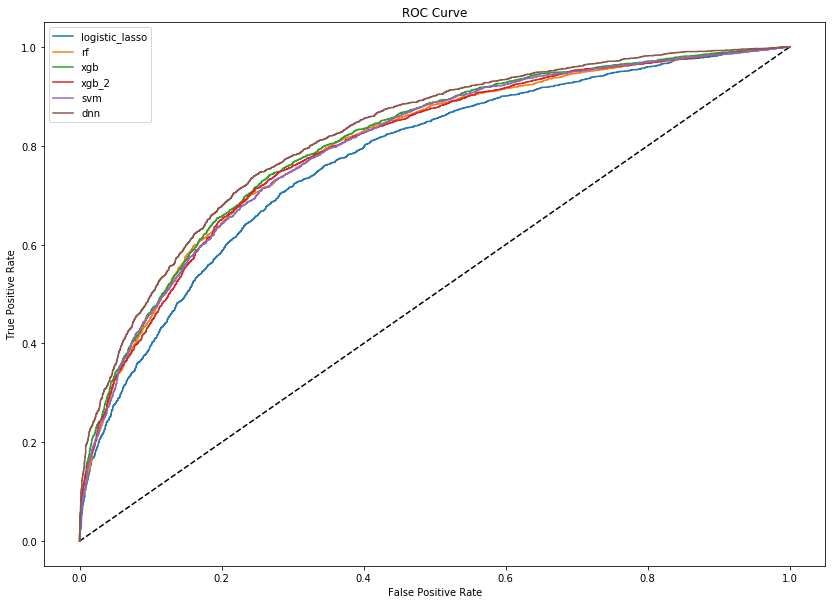

In [46]:
names_models = ['logistic_lasso', 'rf', 'xgb']
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot([0, 1], [0, 1], 'k--')
for idx, model_i in enumerate([model_logistic, model_rf, model_xgb]):
    fpr, tpr, thresholds = roc_curve(y_test, model_i.predict_proba(X_test)[:,1])
    plt.plot(fpr, tpr, label=names_models[idx])

fpr, tpr, thresholds = roc_curve(y_test, bst.predict(dtest))
plt.plot(fpr, tpr, label='xgb_2')

fpr, tpr, thresholds = roc_curve(y_test, model_svm_proba.predict_proba(X_test_svm)[:,1])
plt.plot(fpr, tpr, label='svm')

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test_svm))
plt.plot(fpr, tpr, label='dnn')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()